In [30]:
import numpy as np
import pandas as pd
from pyproj import Transformer
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN, KMeans, AffinityPropagation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from math import *
from matplotlib.colors import Normalize
import geopandas as gpd
from shapely.geometry import shape, LineString, Point
from shapely.wkt import loads  # To load WKT strings into Shapely objects
import os
import fiona

%matplotlib inline

In [72]:
filepath = "c:\\Users\\archo\\Pawnee\\lit_review\\faults\\OF3-2015.shp"

# Open the shapefile
data = []
with fiona.open(filepath) as shp:
    for feature in shp:
        try:
            geom = shape(feature["geometry"])
            data.append({
                "id": feature["properties"]["id"],
                "name": feature["properties"]["name"],
                "geometry": geom.wkt
            })
        except Exception as e:
            print(f"Skipping invalid geometry: {e}")

df = pd.DataFrame(data)

def extract_coordinates(row_number):
    geom_wkt = df.loc[row_number, "geometry"]
    geom = loads(geom_wkt)
    if geom.geom_type == "LineString":
        coords = list(geom.coords)
        lats = [coord[1] for coord in coords]
        lons = [coord[0] for coord in coords]
        coords_df = pd.DataFrame({"latitude": lats, "longitude": lons})
        coords_df["id"] = row_number  # Add row number as ID
        return coords_df
    else:
        raise ValueError(f"Row {row_number} is not a LINESTRING!")

consolidated_df = pd.DataFrame(columns=["id", "latitude", "longitude"])

for row_number in range(len(df)):
    try:
        temp_df = extract_coordinates(row_number)
        consolidated_df = pd.concat([consolidated_df, temp_df], ignore_index=True)
    except ValueError as e:
        print(f"Skipping row {row_number}: {e}")

consolidated_df = consolidated_df[(consolidated_df['latitude']>36.3) & (consolidated_df['latitude']<36.6) & (consolidated_df['longitude']<-96.75) & (consolidated_df['longitude']>-97.1)]

consolidated_df.loc[len(consolidated_df)] = [10000000, 36.3948003327787,-96.79999822596872]
consolidated_df.loc[len(consolidated_df)] = [10000000, 36.431239600665556,-96.98168194427916]


Skipping invalid geometry: IllegalArgumentException: point array must contain 0 or >1 elements



C:\Users\archo\AppData\Local\Temp\ipykernel_20648\1002390464.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  consolidated_df = pd.concat([consolidated_df, temp_df], ignore_index=True)


Skipping row 55: Row 55 is not a LINESTRING!


In [32]:
cat1 = pd.read_csv('10950_2019_9864_MOESM2_ESM.csv')
cat2 = pd.read_csv('SRL_2017007_esupp_matched_filter_cat_pawnee.csv',delimiter="\t")

# filter out everything except Pawnee
cat1 = cat1[(cat1['lat']>36.3) & (cat1['lat']<36.6) & (cat1['long']<-96.75) & (cat1['long']>-97.1)]

In [47]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
cat1[['x', 'y']] = cat1.apply(
    lambda row: transformer.transform(row['long'], row['lat']), axis=1, result_type='expand'
)
cat2[['x', 'y']] = cat2.apply(
    lambda row: transformer.transform(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

df = cat1

lon_var = "long" if "long" in df.columns else "longitude"
lat_var = "lat" if "lat" in df.columns else "latitude"
df.drop_duplicates()

,year,month,day,hour,minute,second,lat,long,depth,mag,x,y
18451,2011,12,18,9,32,7.82,36.38122,-96.93248,2.487,1.41632,-1.079047e+07,4.353204e+06
18457,2011,12,18,11,35,10.45,36.38122,-96.93248,2.487,1.45126,-1.079047e+07,4.353204e+06
18463,2011,12,18,21,43,24.34,36.38122,-96.93248,2.487,1.56777,-1.079047e+07,4.353204e+06
18793,2011,12,25,11,11,49.92,36.38122,-96.93248,2.487,1.49907,-1.079047e+07,4.353204e+06
20070,2012,2,20,22,7,14.93,36.42580,-96.90948,5.126,3.11846,-1.078791e+07,4.359370e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
209384,2016,12,30,18,47,13.17,36.44808,-96.88112,5.477,1.74957,-1.078476e+07,4.362453e+06
209387,2016,12,30,19,20,21.15,36.44872,-96.87959,8.014,2.18439,-1.078459e+07,4.362542e+06
209390,2016,12,30,19,45,13.42,36.43382,-96.90550,4.680,2.17865,-1.078747e+07,4.360480e+06
209404,2016,12,30,22,0,25.84,36.43382,-96.90550,4.680,1.88090,-1.078747e+07,4.360480e+06


In [73]:
# Combine the two catalogs
cat_combined = pd.DataFrame({
    'lat': pd.concat([cat1['lat'],cat2['latitude']]),
    'long': pd.concat([cat1['long'],cat2['longitude']]),
    'depth': pd.concat([cat1['depth'],cat2['depth']]),
    'mag': pd.concat([cat1['mag'],cat2['magnitude']]),
    'x': pd.concat([cat1['x'],cat2['x']]),
    'y': pd.concat([cat1['y'],cat2['y']]),
})

cat_combined.reset_index(drop=True, inplace=True)

df = cat_combined
lon_var = "long" if "long" in df.columns else "longitude"
lat_var = "lat" if "lat" in df.columns else "latitude"

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11925 entries, 0 to 11924
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     11925 non-null  float64
 1   long    11925 non-null  float64
 2   depth   11925 non-null  float64
 3   mag     11925 non-null  float64
 4   x       11925 non-null  float64
 5   y       11925 non-null  float64
dtypes: float64(6)
memory usage: 559.1 KB


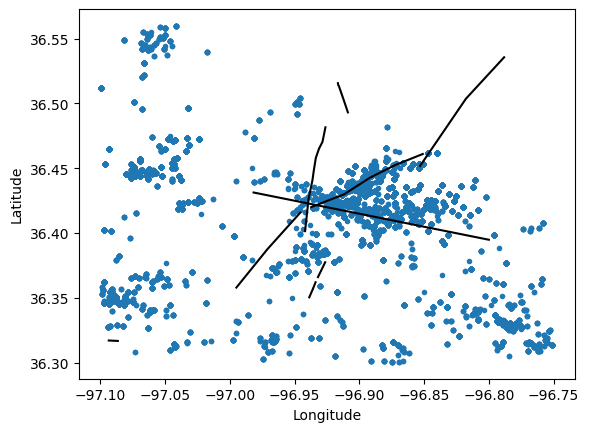

,lat,long,depth,mag,x,y
0,36.38122,-96.93248,2.487,1.41632,-1.079047e+07,4.353204e+06
1,36.38122,-96.93248,2.487,1.45126,-1.079047e+07,4.353204e+06
2,36.38122,-96.93248,2.487,1.56777,-1.079047e+07,4.353204e+06
3,36.38122,-96.93248,2.487,1.49907,-1.079047e+07,4.353204e+06
4,36.42580,-96.90948,5.126,3.11846,-1.078791e+07,4.359370e+06
...,...,...,...,...,...,...
11919,36.43710,-96.83610,0.000,0.72000,-1.077975e+07,4.360934e+06
11921,36.43080,-96.89220,0.000,0.77000,-1.078599e+07,4.360062e+06
11922,36.38350,-96.92740,0.000,1.09000,-1.078991e+07,4.353520e+06
11923,36.41700,-96.86280,0.000,0.93000,-1.078272e+07,4.358153e+06


In [74]:
# Outlier removal
%matplotlib inline
z_thres = 3.0
z_scores = (df - df.mean())/df.std()
outliers = (z_scores.abs() > z_thres).any(axis=1)
df_cleaned = df[~outliers]

#df_cleaned = df # <--------------------- Uncomment if outliers need not be removed

plt.plot(df_cleaned[lon_var],df_cleaned[lat_var],'.')
for fault_id in consolidated_df["id"].unique():
    fault_data = consolidated_df[consolidated_df["id"] == fault_id]
    plt.plot(fault_data["longitude"], fault_data["latitude"], '-', label=f'Fault {fault_id}',color='black')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

df_cleaned


In [ ]:
# clustering


X = df_cleaned[[lat_var,lon_var]]

method = "hdb" # <---------------------------- CHANGE THIS TO USE DIFFERENT CLUSTERING METHOD
if method == "hdb":
    hdb = HDBSCAN(min_cluster_size=70)
    cluster_labels = hdb.fit_predict(X)
elif method=="kmn":
    kmeans = KMeans(n_clusters=10)
    cluster_labels = kmeans.fit_predict(X)
elif method=="afp":
    affinityp = AffinityPropagation()
    cluster_labels = affinityp.fit_predict(X)
mask = cluster_labels!=-1

include_noise = False # <---------------------- CHANGE THIS TO INCLUDE ALL EARTHQUAKES

if include_noise:
    X_train = X[mask]
    y_train = cluster_labels[mask]
    X_noise = X[not mask]

    knn = KNeighborsClassifier(n_neighbors=90)
    knn.fit(X_train, y_train)

    if not X_noise.empty:
        noise_labels = knn.predict(X_noise)
        cluster_labels[not mask] = noise_labels

df_cleaned['cluster'] = cluster_labels

df_cleaned = df_cleaned[df_cleaned['cluster']!=-1]
centroids = df_cleaned.groupby('cluster')[[lat_var, lon_var]].mean()

%matplotlib qt

for cluster, centroid in centroids.iterrows():
    plt.text(centroid[lon_var], centroid[lat_var], str(cluster), fontsize=12, ha='center', va='center', color='black')

plt.scatter(df_cleaned[lon_var], df_cleaned[lat_var], c=df_cleaned['cluster'], cmap='tab10', s=8)
plt.colorbar(label='Cluster Label')
for fault_id in consolidated_df["id"].unique():
    fault_data = consolidated_df[consolidated_df["id"] == fault_id]
    plt.plot(fault_data["longitude"], fault_data["latitude"], '-', label=f'Fault {fault_id}',color='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Merge clusters based on distance threshold
threshold = 0.05  # Define a threshold for merging clusters
groups = []
visited = set()

for i, centroid1 in centroids.iterrows():
    if i in visited:
        continue
    group = {i}
    for j, centroid2 in centroids.iterrows():
        if i != j:
            dist = sqrt((centroid1[lon_var] - centroid2[lon_var])**2 +
                        (centroid1[lat_var] - centroid2[lat_var])**2)
            if dist < threshold:
                group.add(j)
                visited.add(j)
    groups.append(group)



df_cleaned.to_csv('cleaned_skoumal_2020_clustered.csv')


C:\Users\archo\AppData\Local\Temp\ipykernel_20648\3291252170.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cluster'] = cluster_labels


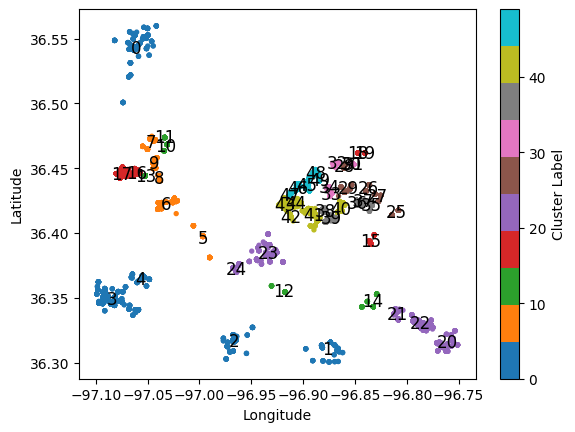

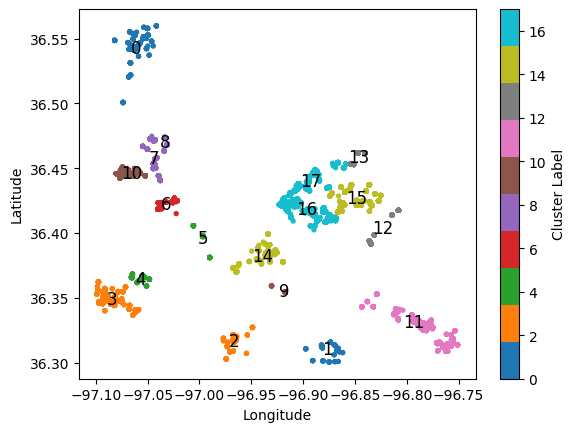

In [87]:
# Preferred groups from manual checking
%matplotlib inline
df_cleaned = pd.read_csv('cleaned_skoumal_2020_clustered.csv')
df_cleaned = df_cleaned[df_cleaned['cluster']!=-1]
centroids = df_cleaned.groupby('cluster')[['lat', 'long']].mean()


for cluster, centroid in centroids.iterrows():
    plt.text(centroid['long'], centroid['lat'], str(cluster), fontsize=12, ha='center', va='center', color='black')

plt.scatter(df_cleaned['long'], df_cleaned['lat'], c=df_cleaned['cluster'], cmap='tab10', s=8)
plt.colorbar(label='Cluster Label')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


groups = [{0},{1},{2},{3},{4},{5},{6},{7,8,9},{10,11},{12},{13,16,17},{14,20,21,22},{15,25},{18,19,30,31},{23,24},{26,27,29,33,35,36,37,40},{34,38,39,41,42,43,44},{28,32,45,46,47,48,49}]
          
cluster_mapping = {}

for new_label, group in enumerate(groups):
    for old_label in group:
        cluster_mapping[old_label] = new_label

df_cleaned['merged_cluster'] = df_cleaned['cluster'].map(cluster_mapping)


centroids = df_cleaned.groupby('merged_cluster')[['lat', 'long']].mean()


for cluster, centroid in centroids.iterrows():
    plt.text(centroid['long'], centroid['lat'], str(cluster), fontsize=12, ha='center', va='center', color='black')

plt.scatter(df_cleaned['long'], df_cleaned['lat'], c=df_cleaned['merged_cluster'], cmap='tab10', s=8)
plt.colorbar(label='Cluster Label')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()




In [ ]:
%matplotlib qt

cmap = plt.get_cmap('tab20')
norm = Normalize(vmin=df_cleaned['merged_cluster'].min(), vmax=df_cleaned['merged_cluster'].max())

depth_norm = Normalize(vmin=df_cleaned['depth'].min(), vmax=df_cleaned['depth'].max())
mag_norm = Normalize(vmin=df_cleaned['mag'].min(),vmax=df_cleaned['mag'].max())
alpha_values = depth_norm(df_cleaned['depth'])
size_values = mag_norm(df_cleaned['mag'])

plt.scatter(
    df_cleaned['long'], 
    df_cleaned['lat'], 
    c=df_cleaned['merged_cluster'], 
    cmap='tab20', 
    s=40*size_values,
    alpha=alpha_values
)
plt.colorbar(label='Cluster Label')

cluster_type = "merged_cluster"
for cluster in df_cleaned[cluster_type].unique():
    cluster_data = df_cleaned[df_cleaned[cluster_type] == cluster]
    X = cluster_data['long'].values.reshape(-1, 1)
    y = cluster_data['lat'].values
    model = LinearRegression()
    model.fit(X, y)

    x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_vals = model.predict(x_vals)

    cluster_color = cmap(norm(cluster))
    
    plt.plot(x_vals, y_vals, label=f'Cluster {cluster} Line', color=cluster_color)

for fault_id in consolidated_df["id"].unique():
    fault_data = consolidated_df[consolidated_df["id"] == fault_id]
    plt.plot(fault_data["longitude"], fault_data["latitude"], '-', label=f'Fault {fault_id}',color='black')

centroids = df_cleaned.groupby('merged_cluster')[['lat', 'long']].mean()


for cluster, centroid in centroids.iterrows():
    plt.text(centroid['long'], centroid['lat'], str(cluster), fontsize=12, ha='center', va='center', color='black')

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()
